In [15]:
# Import statements
import os
import traceback
import pickle
import pdb
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from LearningSession import *
from LearningChoicePredictor import *
from LearningPsychometricPredictor import *
from sklearn.linear_model import LogisticRegression
import ssm

In [16]:
animal = 'mSM63'
folder = '/home/chingf/engram/data/musall/learning/neural/mSM63'
dates = os.listdir(folder)
dates.sort()
dates = dates[1:]
dates.sort(key = lambda date: datetime.strptime(date, '%d-%b-%Y')) 

In [3]:
# Load choice decoding results
choicedecoders = pickle.load(
    open("pickles/choicedecodingreduce1.0_learning_mSM63.p", "rb")
    )

In [54]:
# Create dataset
def _form_data_matrix(task_type):
    aud_dates = range(21, 31)
    audtac_dates = range(31, 41)
    tacaud_dates = range(41, 68)
    if task_type == "aud":
        task_dates = aud_dates
        multimodal = False
    elif task_type == "audtac":
        task_dates = audtac_dates
        multimodal = True
    elif task_type == "tacaud":
        task_dates = tacaud_dates
        multimodal = True
    all_X = []
    all_y = []
    all_indices = []
    is_aud_trial = []
    curr_index = 0

    for date_idx, day_number in enumerate(task_dates):
        date = dates[day_number]
        session = LearningSession(
            animal, date, access_engram=True, load_neural=False
            )
        predictor = LearningPsychometricPredictor(
            session, multimodal=multimodal)
        
        # Collect behavioral covariates
        y = predictor.trial_choices
        X = predictor.data
        
        # Add in choice decoder predictive probability
        # Frames 0-10 are pre-stim, 10-30 are during stim, 30-40 are post-stim
        choicedecoder = choicedecoders[day_number]
        predic_probs = []
        for trial in range(1, session.num_trials + 1):
            trial_predic_probs = []
            for frame in range(len(choicedecoder["predic_prob"])):
                prob = choicedecoder["predic_prob"][frame]
                trial_labels = choicedecoder["trial_labels"][frame]
                idx = np.argwhere(trial_labels == trial)
                if idx.size == 0:
                    trial_predic_probs.append(np.nan)
                else:
                    trial_predic_probs.append(prob[idx[0,0], 1])
            trial_predic_probs = np.array(trial_predic_probs)
            predic_probs.append(trial_predic_probs)
        predic_probs = np.array(predic_probs)
        pre_stim_prob = np.mean(predic_probs[:,:10], axis=1)
        X = np.hstack((X, pre_stim_prob.reshape((-1,1))))
        
        # Post-process predictors: throw out nan trials
        nonnan_covariates = np.logical_not(
            np.sum(np.isnan(X), axis=1)
            )
        nonnan_choices = np.logical_not(np.isnan(y))
        nonnan_indices = np.logical_and(nonnan_covariates, nonnan_choices)
        y = y[nonnan_indices].astype(int) - 1
        y = y.reshape((-1,1))
        X = X[nonnan_indices,:]
        
        # Boolean mask over auditory trials for nonnan trials
        for idx, val in enumerate(nonnan_indices):
            if not val:
                continue
            is_aud_trial.append(session.is_aud_trial[idx])
            
        # Collect into arrays over all relevant sessions
        indices = np.vstack(
            (np.arange(y.size) + curr_index, np.ones(y.size)*date_idx)
            ).T
        all_X.append(X)
        all_y.append(y)
        all_indices.append(indices)
        curr_index += y.size
    all_X = np.vstack(all_X)
    all_y = np.vstack(all_y)
    all_indices = np.vstack(all_indices)
    
    # For testing/debugging
    all_X = all_X[:,-1].reshape((-1,1))
    
    # Split data if there are modality differences trial-by-trial
    if task_type == "aud":
        filename = task_type + "_neurglmhmm_testdata.p"
        _split_data_and_save(all_X, all_y, all_indices, filename)
    else:
        is_tac_trial = np.logical_not(is_aud_trial)
        aud_filename = task_type + "_aud_neurglmhmm_testdata.p"
        aud_X = all_X[is_aud_trial]
        aud_y = all_y[is_aud_trial]
        aud_indices = all_indices[is_aud_trial]
        _split_data_and_save(
            aud_X, aud_y, aud_indices, aud_filename
            )
        tac_filename = task_type + "_tac_neurglmhmm_testdata.p"
        tac_X = all_X[is_tac_trial]
        tac_y = all_y[is_tac_trial]
        tac_indices = all_indices[is_tac_trial]
        _split_data_and_save(
            tac_X, tac_y, tac_indices, tac_filename
            )
    
def _split_data_and_save(all_X, all_y, all_indices, filename):
    data = {
        "X": all_X, "y": all_y, "indices": all_indices
        }
    pickle.dump(data, open(filename, "wb"))

In [53]:
task_type = "aud"
_form_data_matrix(task_type)
task_type = "audtac"
_form_data_matrix(task_type)
task_type = "tacaud"
_form_data_matrix(task_type)

0.8554123711340206
0.7957174501599803
0.8547515720485342


In [12]:
reg_of_interest = [
    'MOB', 'SSp_bfd1', 'SSp_m1', 'SSs1'
    ]
reg = []
vals= []
session_cov = []
for date in dates:
    session = LearningSession(
        animal, date, access_engram=True, load_neural=True
        )
    reg_indices = session.neural['reg_indxs'].item()
    reg_names = session.neural['reg_indxs'].dtype.names
    cov = 0
    for idx, reg_name_rl in enumerate(reg_names):
        reg_name = reg_name_rl[:-2]
        if reg_name not in reg_of_interest:
            continue
        reg_index = reg_indices[idx] - 1
        reg_count = reg_index.flatten().size
        reg.append(reg_name)
        vals.append(reg_count)
        cov += reg_count
    session_cov.append(cov)

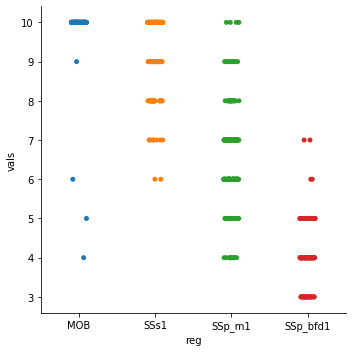

In [13]:
df = pd.DataFrame({
    'reg': reg, 'vals': vals
})
sns.catplot(x='reg', y = 'vals', data=df)

(array([ 5.,  5.,  6., 12.,  8., 17., 15.,  4.,  5.,  3.]),
 array([52. , 53.6, 55.2, 56.8, 58.4, 60. , 61.6, 63.2, 64.8, 66.4, 68. ]),
 <a list of 10 Patch objects>)

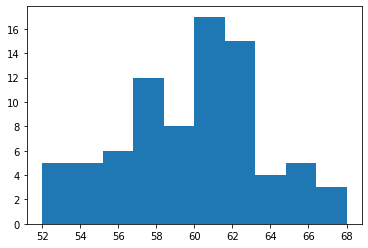

In [14]:
plt.hist(session_cov)